In [54]:
import matplotlib
# matplotlib.use('webagg_core')
# matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from astropy.io import fits
import numpy as np
from scipy.optimize import curve_fit
from pytransit import QuadraticModel
import sys
from wotan import flatten


In [55]:
# define data input params

filename = '../Data/TOI-175/TOI-175_stitched.fits'
# filename = 'slc_new.tbl'
# filename = 'other/slc_new.tbl'
filetype = 'Fits'    # Fits or PlainColsTransit
delimiter = ' '
# t0 = 2454833. # Kepler t0
t0 = 2457000. #Tess t0
normalizeTR = False
flattenTR = False

ownChi2 = True
# Chi2    = True
plotData = False
plotFit  = True
plotAll  = False
silent   = False

# define planet's orbital parameters
Planets = []

'''
# Kepler-9
periods = np.array([19.247, 38.944])
# tperis  = np.array([3526.9, 3541.645])
tperis  = np.array([645.07968714, 641.755])
Rp2Rss  = np.array([0.082, 0.0796])
a2Rss   = np.array([29.285, 46.897])
incs    = np.array([88.63, 89.0]) /180*np.pi
es      = np.array([0.063, 0.068])
oms     = np.array([356.9, 169.3]) /180*np.pi

ldc0    = 0.4089
ldc1    = 0.2623
'''

incDev  = 0.005  # factor for min or max variation of inc for fitting
incVary = False   # fit Inclination as well?
            
minFitRangeFactor = 0.01  # factor (multiplied by len of time(inds)) for width of parabola fit in Chi² space
T0off = 0


# TOI-175
periods = np.array([3.690670, 7.450744])
tperis  = np.array([1356.2031813, 1355.28687])
Rp2Rss  = np.array([0.0391, 0.0448])
a2Rss   = np.array([21.21, 33.97])
incs    = np.array([88.866, 88.435]) /180*np.pi
es      = np.array([0.014, 0.0135])
oms     = np.array([89.23, 46.85]) /180*np.pi

ldc0    = 0.1555
ldc1    = 0.4459


for _ in periods:
    Planets.append({"time": [], "modelFlux": [], "dataFlux": [], 
                    "tperi": [], "tperiGuess": [], "tperiCalc": [],
                    "valErr": [], "tperiErr": []})
    

# define parameters for fit
dT = 0.2 # time for transit data cutout

In [56]:
# read data from input File (fits from lightcurve + BJDREFI/F)

if filetype == 'Fits':
    hdu = fits.open(filename)
    cont = hdu[1].data
    # print(hdu[1].header)

    BJDREFI = hdu[1].header['BJDREFI']  # Integer part of the BJD reference date
    BJDREFF = hdu[1].header['BJDREFF']  # fraction of the day in BTJD reference date  
    BJDcorr = BJDREFI + BJDREFF         # full BJD reference

    time_in  = cont['TIME']
    value_in = cont['FLUX']
    error_in = cont['FLUX_ERR']
    xb       = cont['TIME']
    yb       = cont['FLUX']
    yeb      = cont['FLUX_ERR']

    ind = np.where(np.isfinite(xb))
    xb  = xb[ind]
    yb  = yb[ind]
    yeb = yeb[ind]
    ind = np.where(np.isfinite(yb))
    xb  = xb[ind]
    yb  = yb[ind]
    yeb = yeb[ind]
    ind = np.where(np.isfinite(yeb))
    xb  = xb[ind]
    yb  = yb[ind]
    yeb = yeb[ind]

    time_in = xb + BJDcorr 
    value_in = yb
    value_in_median = 1.
    if normalizeTR: 
        value_in_median = np.median(value_in)
        print('normalizing ',filename)
    error_in = yeb

    time     = xb + BJDcorr - t0
    value    = yb/np.median(yb)
    error    = yeb/np.median(yb)
    hdu.close()

elif filetype == "PlainColsTransit":
    cont = np.genfromtxt(filename,names=['x','y','ye'],delimiter=delimiter,comments='#')
    time_in  = cont['x']
    time     = cont['x']
    value_in = cont['y']
    value_in_median = 1.
    if normalizeTR: 
        value_in_median = np.median(value_in)


    value    = cont['y'] /value_in_median
    error    = cont['ye']/value_in_median
    error_in = cont['ye']
    
if flattenTR:
    value, trend_lc = flatten(time, value, window_length=0.5, method='biweight', return_trend=True)


print(time[:],len(time),value[:],len(value))

[1354.10882313 1354.11021199 1354.11298971 ... 2279.97691584 2279.97830475
 2279.97969366] 178552 [1.0010141 1.0004257 0.9998176 ... 0.9997055 1.0011019 0.9998087] 178552


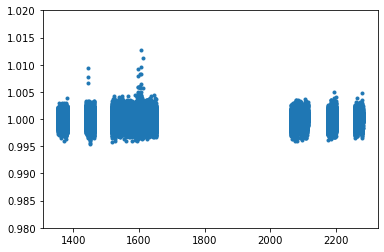

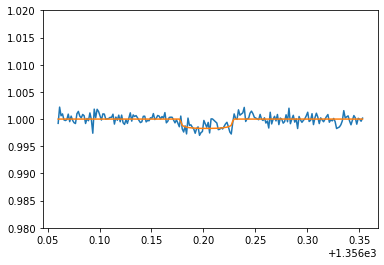

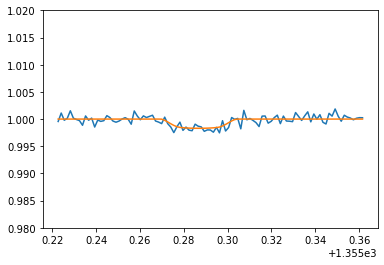

In [57]:
# first test:

plt.plot(time[:], value[:], '.') # plot data
# plt.xlim((645,647))
plt.ylim((0.98,1.02))
plt.show()
# setup Model
# Plot Planet
Plan = 0
PlanModel = QuadraticModel()
PlanModel.set_data(time)
flux = PlanModel.evaluate(k=Rp2Rss[Plan], ldc=[ldc0,ldc1], t0=tperis[Plan], p=periods[Plan], a=a2Rss[Plan], i=incs[Plan], e=es[Plan], w=oms[Plan])
# for kepler-9 planet 1
#plt.plot(time[16700:17200], value[16700:17200])  # plot model
#plt.plot(time[16700:17200], flux[16700:17200])  # plot model
# for TOI-175 Planet 0
plt.plot(time[1400:1600], value[1400:1600])
plt.plot(time[1400:1600], flux[1400:1600])
plt.ylim((0.98,1.02))
plt.show()
# for TOI-175 Planet 1
Plan = 1
flux = PlanModel.evaluate(k=Rp2Rss[Plan], ldc=[ldc0,ldc1], t0=tperis[Plan], p=periods[Plan], a=a2Rss[Plan], i=incs[Plan], e=es[Plan], w=oms[Plan])
plt.plot(time[800:900], value[800:900])  # plot model
plt.plot(time[800:900], flux[800:900])  # plot model
plt.ylim((0.98,1.02))

plt.show()

In [58]:
from lmfit import minimize, Parameters, fit_report
##################################################################
# mapping predicted transit midpoints to data,
# cutout time and data
# fit model to data

PlanModel = QuadraticModel()
PlanModel.set_data(time)

def model(inds, params):
    ##############################################################
    # new definition of the model lightcurve with an array as input
    return params["off"]+PlanModel.evaluate(k   = params["Rp2Rs"].value, 
                                            ldc = [params["ldc0"].value, params["ldc1"].value],
                                            t0  = params["T0"].value,
                                            p   = params["P"].value,
                                            a   = params["a2Rs"].value,
                                            i   = params["inc"].value,
                                            e   = params["e"].value,
                                            w   = params["om"].value)[inds]

def chi2(params, inds, data, error): # Rp2Rs=0.1, ldc=[0.2,0.4], P=5, a2Rs=5, inc=0.5*np.pi, e=0, om=0.5*np.pi):
    ##############################################################
    # calculate and return Chi-square
    return np.sum((data-model(inds, params))**2/error**2)

def res(params, inds, data, error):
    return (model(inds, params)-data)/error

################################
# start Planet  1
	Transit: 1
		Ttra guess: 1356.2031813
		Chi2 min: 1356.2030191843876 (^0.0029904433979481837 _-0.00256502474780973)


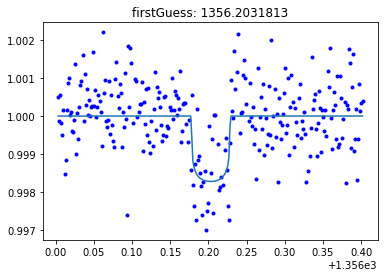

	Transit: 2
		off: -0.00016211561251111561
		Ttra guess: 1359.8936891843875
		Chi2 min: 1359.8930486084398 (^0.0017934332165623346 _-0.0023731708031391463)


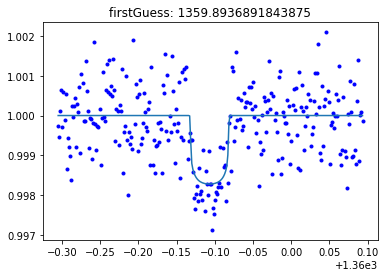

	Transit: 3
		off: -0.0006405759477274842
		Ttra guess: 1363.5837186084398
		Chi2 min: 1363.5867235494163 (^-0.0002711002100568294 _-0.0016599675957422733)


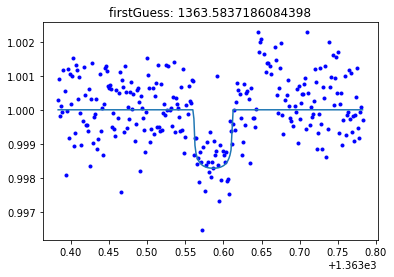

	Transit: 4
		off: 0.0030049409765524615
		Ttra guess: 1367.2773935494163
time array for chi2 empty
	Transit: 5
		off: 0.0
		Ttra guess: 1370.9680635494162
		skip_penalty: 1
		Chi2 min: 1370.9643637871875 (^0.002527497844539539 _-0.0030279926529601653)


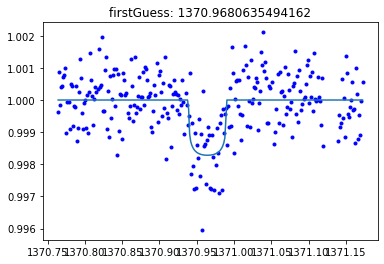

	Transit: 6
		off: -0.003699762228734471
		Ttra guess: 1374.6550337871874
		Chi2 min: 1374.6579953748612 (^0.0019102227063285682 _-0.002256398542840543)


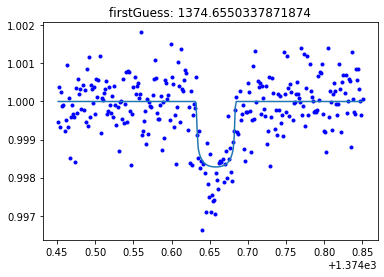

	Transit: 7
		off: 0.002961587673780741
		Ttra guess: 1378.3486653748612
		Chi2 min: 1378.345659380071 (^-0.0010718933681346243 _-0.002460766341755516)


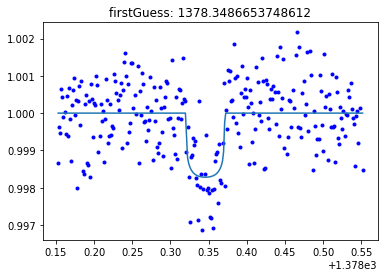

	Transit: 8
		off: -0.0030059947901008854
		Ttra guess: 1382.036329380071
		 [] []
		no data points available
	Transit: 9
		off: 0.0
		Ttra guess: 1385.726999380071
		 [] []
		no data points available
	Transit: 10
		off: 0.0
		Ttra guess: 1389.417669380071
		 [] []
		no data points available
	Transit: 11
		off: 0.0
		Ttra guess: 1393.108339380071
		 [] []
		no data points available
	Transit: 12
		off: 0.0
		Ttra guess: 1396.7990093800709
		 [] []
		no data points available
	Transit: 13
		off: 0.0
		Ttra guess: 1400.4896793800708
		 [] []
		no data points available
	Transit: 14
		off: 0.0
		Ttra guess: 1404.1803493800708
		 [] []
		no data points available
	Transit: 15
		off: 0.0
		Ttra guess: 1407.8710193800707
		 [] []
		no data points available
	Transit: 16
		off: 0.0
		Ttra guess: 1411.5616893800707
		 [] []
		no data points available
	Transit: 17
		off: 0.0
		Ttra guess: 1415.2523593800706
		 [] []
		no data points available
	Transit: 18
		off: 0.0
		Ttra guess: 1418.9430293800706


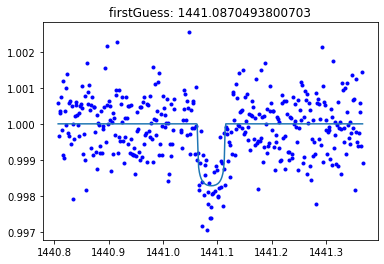

	Transit: 25
		off: 0.001564479627631954
		Ttra guess: 1444.779283859698
		Chi2 min: 1444.7783432292904 (^0.0024399760027336015 _-0.0017267523485315905)


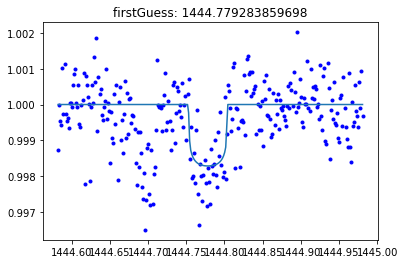

	Transit: 26
		off: -0.0009406304075127991
		Ttra guess: 1448.4690132292903
		Chi2 min: 1448.471072968424 (^4.170895294919319e-05 _-0.0027361073091469734)


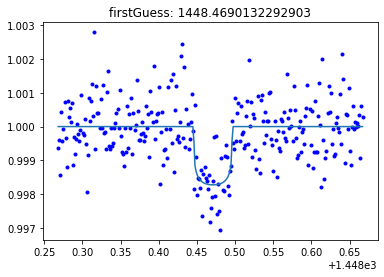

	Transit: 27
		off: 0.002059739133756011
		Ttra guess: 1452.161742968424
		Chi2 min: 1452.1572843856884 (^0.0027653098331938963 _-0.0014014241060067434)


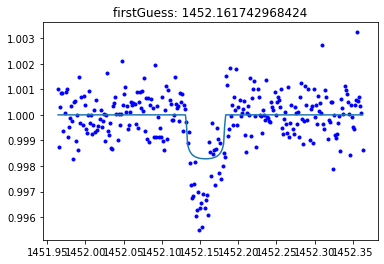

	Transit: 28
		off: -0.004458582735651362
		Ttra guess: 1455.8479543856884
		Chi2 min: 1455.8511689385712 (^0.002002038868567979 _-0.002164704849519694)


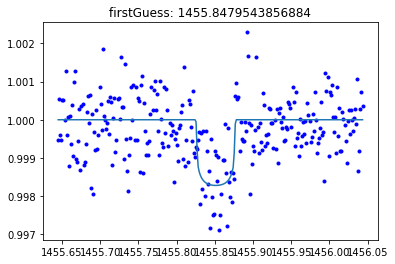

	Transit: 29
		off: 0.003214552882809585
		Ttra guess: 1459.5418389385711
		Chi2 min: 1459.5408855488065 (^0.002631847047496194 _-0.001534896670591479)


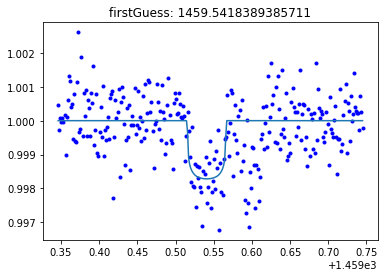

	Transit: 30
		off: -0.0009533897646178957
		Ttra guess: 1463.2315555488065
		Chi2 min: 1463.2314082365021 (^0.002452491363101217 _-0.0017142416447768483)


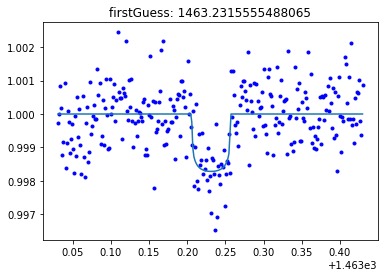

	Transit: 31
		off: -0.00014731230430697906
		Ttra guess: 1466.922078236502
		 [] []
		no data points available
	Transit: 32
		off: 0.0
		Ttra guess: 1470.612748236502
		 [] []
		no data points available
	Transit: 33
		off: 0.0
		Ttra guess: 1474.303418236502
		 [] []
		no data points available
	Transit: 34
		off: 0.0
		Ttra guess: 1477.994088236502
		 [] []
		no data points available
	Transit: 35
		off: 0.0
		Ttra guess: 1481.684758236502
		 [] []
		no data points available
	Transit: 36
		off: 0.0
		Ttra guess: 1485.3754282365019
		 [] []
		no data points available
	Transit: 37
		off: 0.0
		Ttra guess: 1489.0660982365018
		 [] []
		no data points available
	Transit: 38
		off: 0.0
		Ttra guess: 1492.7567682365018
		 [] []
		no data points available
	Transit: 39
		off: 0.0
		Ttra guess: 1496.4474382365017
		 [] []
		no data points available
	Transit: 40
		off: 0.0
		Ttra guess: 1500.1381082365017
		 [] []
		no data points available
	Transit: 41
		off: 0.0
		Ttra guess: 1503.828778236501

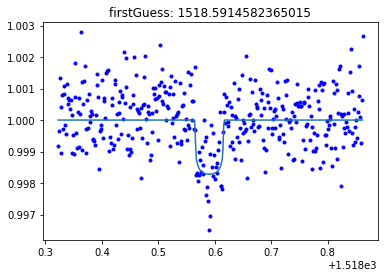

	Transit: 46
		off: -0.0012888755243238847
		Ttra guess: 1522.280839360977
		Chi2 min: 1522.2808341467628 (^0.0015015346123163908 _-0.0026652230756099016)


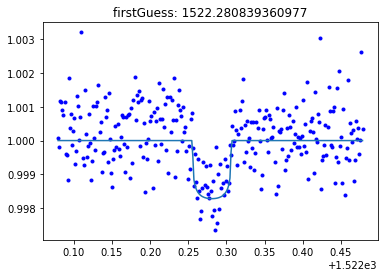

	Transit: 47
		off: -5.214214297666331e-06
		Ttra guess: 1525.9715041467628
		Chi2 min: 1525.972544797267 (^0.0015348987290053628 _-0.002631850577017758)


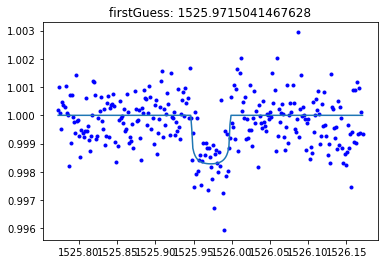

	Transit: 48
		off: 0.0010406505041373748
		Ttra guess: 1529.6632147972668
		 [] []
		no data points available
	Transit: 49
		off: 0.0
		Ttra guess: 1533.3538847972668
		 [] []
		no data points available
	Transit: 50
		off: 0.0
		Ttra guess: 1537.0445547972668
		skip_penalty: 2
		Chi2 min: 1537.043875108192 (^0.001242932213244785 _-0.002923810107859026)


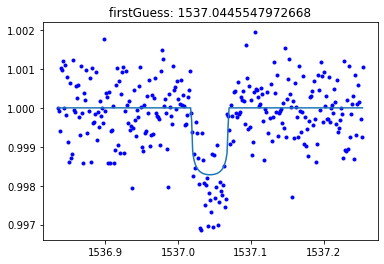

	Transit: 51
		off: -0.0006796890747864381
		Ttra guess: 1540.734545108192
		Chi2 min: 1540.7351868836693 (^0.001660018272787056 _-0.0011178012489381217)


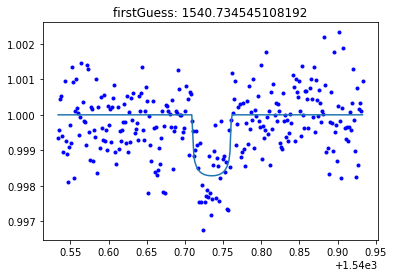

	Transit: 52
		off: 0.0006417754773337947
		Ttra guess: 1544.4258568836692
		Chi2 min: 1544.4254275112758 (^0.0017476101061220106 _-0.0024191261613850656)


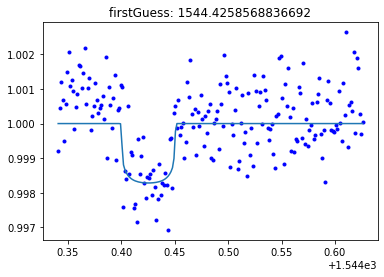

	Transit: 53
		off: -0.0004293723934551963
		Ttra guess: 1548.1160975112757
		Chi2 min: 1548.1145726729494 (^0.0015515756483637233 _-0.0026151554968691926)


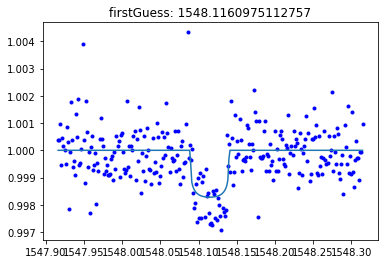

	Transit: 54
		off: -0.0015248383263042342
		Ttra guess: 1551.8052426729494
		Chi2 min: 1551.805984030549 (^0.001860218051206175 _-0.0023065033151397074)


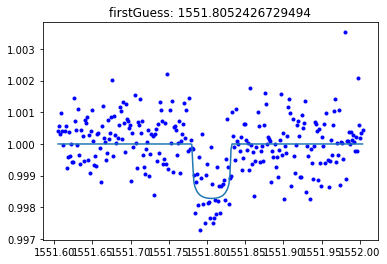

	Transit: 55
		off: 0.0007413575997361477
		Ttra guess: 1555.496654030549
		Chi2 min: 1555.4984983043346 (^0.0010524484728193784 _-0.0017253482315027213)


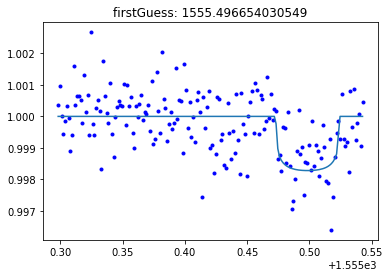

	Transit: 56
		off: 0.0018442737855366431
		Ttra guess: 1559.1891683043345
		Chi2 min: 1559.1877796016452 (^0.0020896149981126655 _-0.0020771026429429185)


	Transit: 57
		off: -0.001388702689382626
		Ttra guess: 1562.8784496016451
		Chi2 min: 1562.8789874023573 (^0.0012012136353405367 _-0.0029654956238118757)


	Transit: 58
		off: 0.0005378007122089912
		Ttra guess: 1566.5696574023573
		Chi2 min: 1566.5690638874466 (^0.0014347783480843646 _-0.002731917406890716)


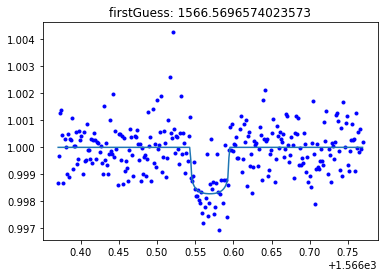

	Transit: 59
		off: -0.0005935149106335302
		Ttra guess: 1570.2597338874466
time array for chi2 empty
	Transit: 60
		off: 0.0
		Ttra guess: 1573.9504038874466
		skip_penalty: 1
		Chi2 min: 1573.9499675063207 (^0.0011261333920629113 _-0.0016516623809366138)


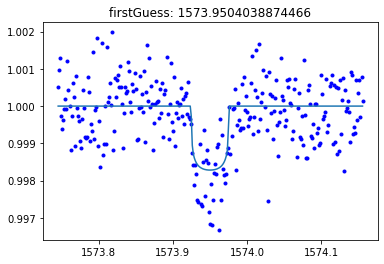

	Transit: 61
		off: -0.0004363811258372152
		Ttra guess: 1577.6406375063207
		Chi2 min: 1577.642271642033 (^0.001897739321066183 _-0.0022689447923767148)


	Transit: 62
		off: 0.0016341357122655609
		Ttra guess: 1581.332941642033
		Chi2 min: 1581.3310188535322 (^0.0020478804874528578 _-0.0021187845338772604)


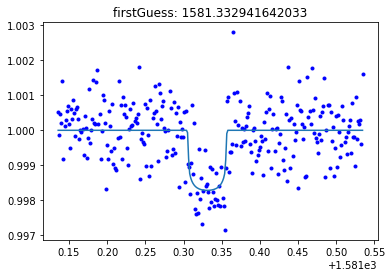

	Transit: 63
		off: -0.0019227885006785073
		Ttra guess: 1585.0216888535322
		Chi2 min: 1585.021492782411 (^0.0018518563463203463 _-0.0023148203165419545)


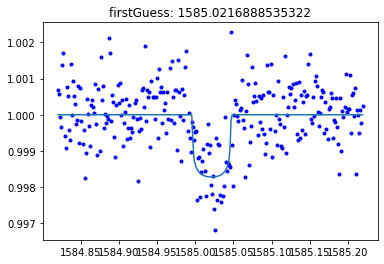

	Transit: 64
		off: -0.0001960711210813315
		Ttra guess: 1588.712162782411
		Chi2 min: 1588.7131071314616 (^0.0019102450060017873 _-0.002256424671941204)


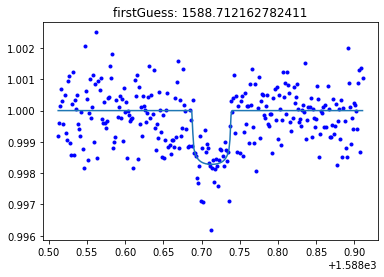

	Transit: 65
		off: 0.0009443490505418595
		Ttra guess: 1592.4037771314615
		Chi2 min: 1592.4044380467878 (^0.0022439062101966556 _-0.0019227522918754403)


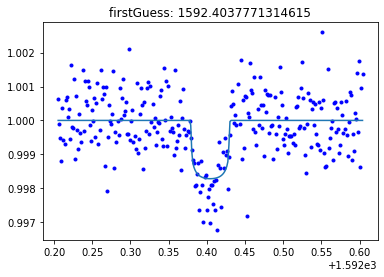

	Transit: 66
		off: 0.0006609153263070766
		Ttra guess: 1596.0951080467878
		 [] []
		no data points available
	Transit: 67
		off: 0.0
		Ttra guess: 1599.7857780467878
		skip_penalty: 1
		Chi2 min: 1599.784923655855 (^0.0008925563297452754 _-0.0018852124348995858)


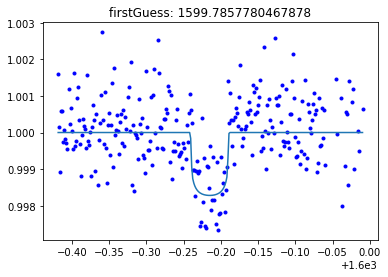

	Transit: 68
		off: -0.0008543909327727306
		Ttra guess: 1603.475593655855
		Chi2 min: 1603.4753892021502 (^0.0020784567793725728 _-0.003477070505368829)


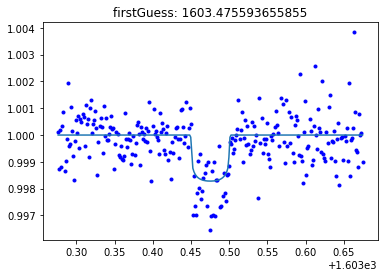

	Transit: 69
		off: -0.00020445370478228142
		Ttra guess: 1607.16605920215
		Chi2 min: 1607.1672129134756 (^0.0005088381360565108 _-0.0022689175900723058)


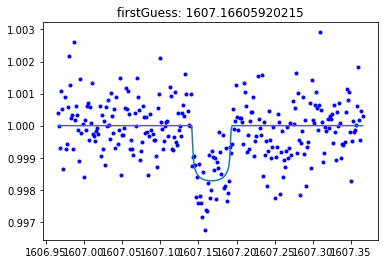

	Transit: 70
		off: 0.0011537113255144504
		Ttra guess: 1610.8578829134756
		 [] []
		no data points available
	Transit: 71
		off: 0.0
		Ttra guess: 1614.5485529134755
		skip_penalty: 1
		Chi2 min: 1614.5485101056568 (^0.0024732855797537923 _-0.0016933454483023525)


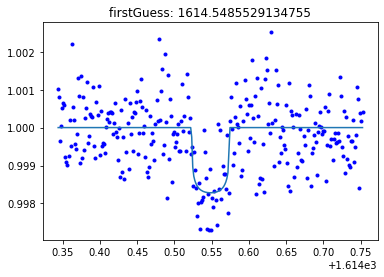

	Transit: 72
		off: -4.2807818772416795e-05
		Ttra guess: 1618.2391801056567
		Chi2 min: 1618.2393910278784 (^0.001835149318594631 _-0.000942599422614876)


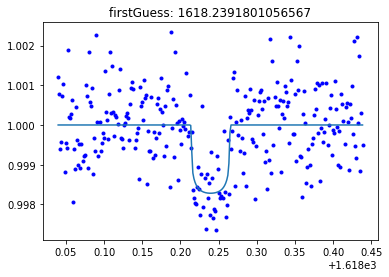

	Transit: 73
		off: 0.0002109222216404305
		Ttra guess: 1621.9300610278783
		Chi2 min: 1621.929304399873 (^0.0007674238916024478 _-0.002010316933365175)


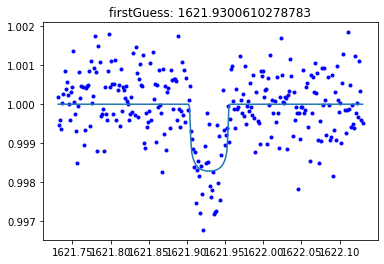

	Transit: 74
		off: -0.0007566280053197261
		Ttra guess: 1625.619974399873
		Chi2 min: 1625.6209145056393 (^0.002160463637437715 _-0.0020061445732153516)


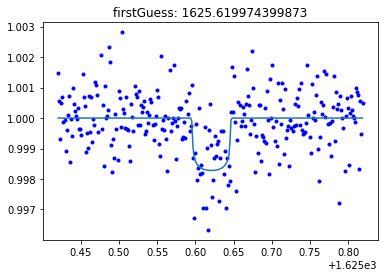

	Transit: 75
		off: 0.0009401057664035761
		Ttra guess: 1629.3115845056393
		Chi2 min: 1629.312036625056 (^-0.00012095267175027402 _-0.0028986934967178968)


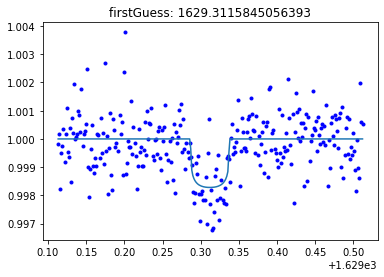

	Transit: 76
		off: 0.00045211941665002087
		Ttra guess: 1633.002706625056
		Chi2 min: 1633.0018783801922 (^0.00026275881214132824 _-0.001126109039205403)


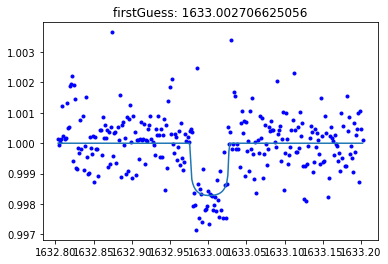

	Transit: 77
		off: -0.0008282448636691697
		Ttra guess: 1636.6925483801922
		Chi2 min: 1636.6929218760515 (^0.002214675228060514 _-0.001951917150108784)


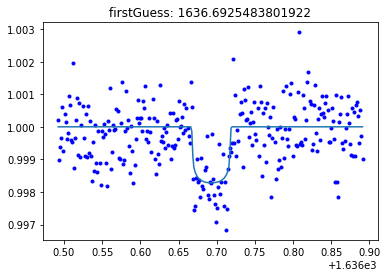

	Transit: 78
		off: 0.0003734958593213378
		Ttra guess: 1640.3835918760515
		Chi2 min: 1640.383831621462 (^0.001509817002897762 _-0.0012679126461989654)


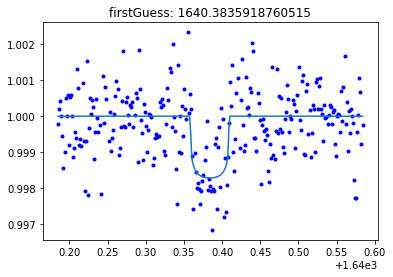

	Transit: 79
		off: 0.00023974541045390652
		Ttra guess: 1644.0745016214619
		Chi2 min: 1644.0737801731548 (^0.0017767462895790231 _-0.002389848882557999)


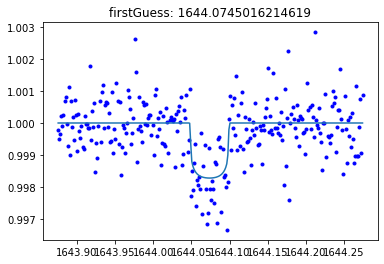

	Transit: 80
		off: -0.0007214483071038558
		Ttra guess: 1647.7644501731547
		Chi2 min: 1647.7682378683585 (^0.003086361999521614 _-0.0010802266533573857)


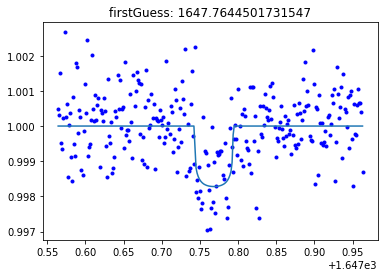

	Transit: 81
		off: 0.0037876952037549927
		Ttra guess: 1651.4589078683584
		Chi2 min: 1651.455886173799 (^0.0014764449640551902 _-0.001301273974831929)


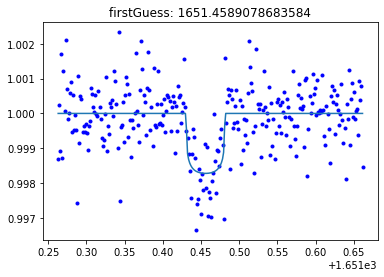

	Transit: 82
		off: -0.003021694559492971
		Ttra guess: 1655.146556173799
		 [] []
		no data points available
	Transit: 83
		off: 0.0
		Ttra guess: 1658.8372261737989
		 [] []
		no data points available
	Transit: 84
		off: 0.0
		Ttra guess: 1662.5278961737988
		 [] []
		no data points available
	Transit: 85
		off: 0.0
		Ttra guess: 1666.2185661737988
		 [] []
		no data points available
	Transit: 86
		off: 0.0
		Ttra guess: 1669.9092361737987
		 [] []
		no data points available
	Transit: 87
		off: 0.0
		Ttra guess: 1673.5999061737987
		 [] []
		no data points available
	Transit: 88
		off: 0.0
		Ttra guess: 1677.2905761737986
		 [] []
		no data points available
	Transit: 89
		off: 0.0
		Ttra guess: 1680.9812461737986
		 [] []
		no data points available
	Transit: 90
		off: 0.0
		Ttra guess: 1684.6719161737985
		 [] []
		no data points available
	Transit: 91
		off: 0.0
		Ttra guess: 1688.3625861737985
		 [] []
		no data points available
	Transit: 92
		off: 0.0
		Ttra guess: 1692.0532561737

		 [] []
		no data points available
	Transit: 170
		off: 0.0
		Ttra guess: 1979.925516173795
		 [] []
		no data points available
	Transit: 171
		off: 0.0
		Ttra guess: 1983.6161861737949
		 [] []
		no data points available
	Transit: 172
		off: 0.0
		Ttra guess: 1987.3068561737948
		 [] []
		no data points available
	Transit: 173
		off: 0.0
		Ttra guess: 1990.9975261737948
		 [] []
		no data points available
	Transit: 174
		off: 0.0
		Ttra guess: 1994.6881961737947
		 [] []
		no data points available
	Transit: 175
		off: 0.0
		Ttra guess: 1998.3788661737947
		 [] []
		no data points available
	Transit: 176
		off: 0.0
		Ttra guess: 2002.0695361737946
		 [] []
		no data points available
	Transit: 177
		off: 0.0
		Ttra guess: 2005.7602061737946
		 [] []
		no data points available
	Transit: 178
		off: 0.0
		Ttra guess: 2009.4508761737945
		 [] []
		no data points available
	Transit: 179
		off: 0.0
		Ttra guess: 2013.1415461737945
		 [] []
		no data points available
	Transit: 180
		off: 0.0


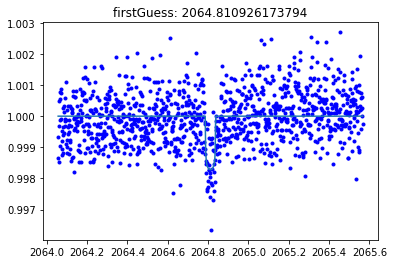

	Transit: 194
		off: 0.00047839026319707045
		Ttra guess: 2068.5020745640572
		Chi2 min: 2068.5008059640086 (^0.0024607421228211024 _-0.0017058367511708639)


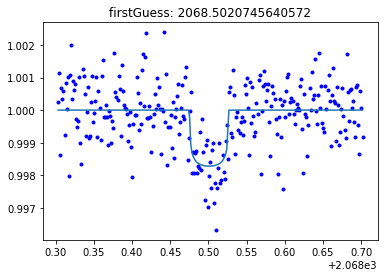

	Transit: 195
		off: -0.0012686000486610283
		Ttra guess: 2072.1914759640085
		 [] []
		no data points available
	Transit: 196
		off: 0.0
		Ttra guess: 2075.8821459640085
		skip_penalty: 1
		Chi2 min: 2075.8859759662164 (^0.0018559885347713134 _-0.002310601515091548)


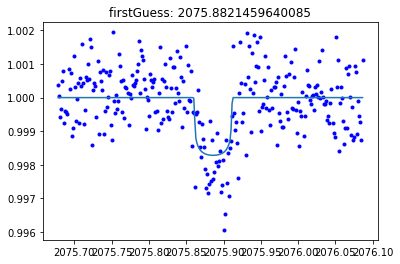

	Transit: 197
		off: 0.003830002207905636
		Ttra guess: 2079.5766459662163
		Chi2 min: 2079.575317716131 (^-5.42201082680549e-05 _-0.0014430828373406257)


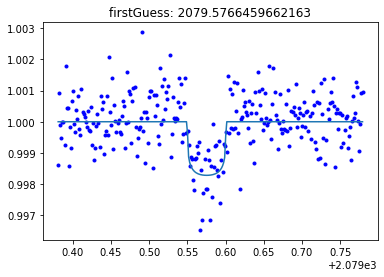

	Transit: 198
		off: -0.0013282500854074897
		Ttra guess: 2083.265987716131
		Chi2 min: 2083.268053763826 (^0.0029737513505097013 _-0.003970562294853153)


	Transit: 199
		off: 0.002066047695279849
		Ttra guess: 2086.958723763826
		 [] []
		no data points available
	Transit: 200
		off: 0.0
		Ttra guess: 2090.649393763826
		skip_penalty: 1
		Chi2 min: 2090.647759408508 (^0.002302266839251388 _-0.0018643353178049438)


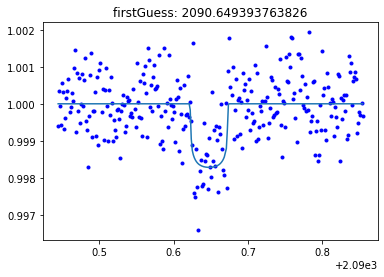

	Transit: 201
		off: -0.0016343553179467563
		Ttra guess: 2094.338429408508
		Chi2 min: 2094.3383678265864 (^0.0005255175738057005 _-0.0022522171975651872)


	Transit: 202
		off: -6.158192172733834e-05
		Ttra guess: 2098.0290378265863
		Chi2 min: 2098.029464607127 (^0.002427389845252037 _-0.0003503449261188507)


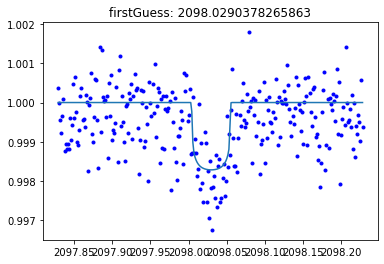

	Transit: 203
		off: 0.00042678054069256177
		Ttra guess: 2101.720134607127
		 [] []
		no data points available
	Transit: 204
		off: 0.0
		Ttra guess: 2105.410804607127
		skip_penalty: 1
		Chi2 min: 2105.4091391012175 (^0.0018184643136009981 _-0.000959281633640785)


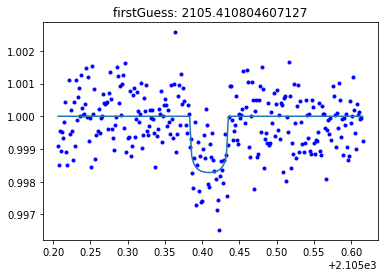

	Transit: 205
		off: -0.001665505909386411
		Ttra guess: 2109.0998091012175
		Chi2 min: 2109.100805666724 (^0.0017767567578630405 _-0.00100098965504003)


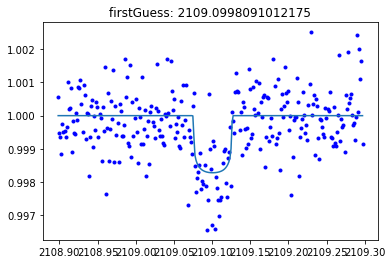

	Transit: 206
		off: 0.000996565506738989
		Ttra guess: 2112.791475666724
time array for chi2 empty
	Transit: 207
		off: 0.0
		Ttra guess: 2116.482145666724
		 [] []
		no data points available
	Transit: 208
		off: 0.0
		Ttra guess: 2120.172815666724
		 [] []
		no data points available
	Transit: 209
		off: 0.0
		Ttra guess: 2123.863485666724
		 [] []
		no data points available
	Transit: 210
		off: 0.0
		Ttra guess: 2127.554155666724
		 [] []
		no data points available
	Transit: 211
		off: 0.0
		Ttra guess: 2131.244825666724
		 [] []
		no data points available
	Transit: 212
		off: 0.0
		Ttra guess: 2134.935495666724
		 [] []
		no data points available
	Transit: 213
		off: 0.0
		Ttra guess: 2138.626165666724
		 [] []
		no data points available
	Transit: 214
		off: 0.0
		Ttra guess: 2142.316835666724
		 [] []
		no data points available
	Transit: 215
		off: 0.0
		Ttra guess: 2146.007505666724
		 [] []
		no data points available
	Transit: 216
		off: 0.0
		Ttra guess: 2149.6981756667237
		 []

	Transit: 224
		off: 0.0013002622054045787
		Ttra guess: 2179.2248359289288
		Chi2 min: 2179.2209067980148 (^0.002640179605805315 _-0.0015265492111211643)


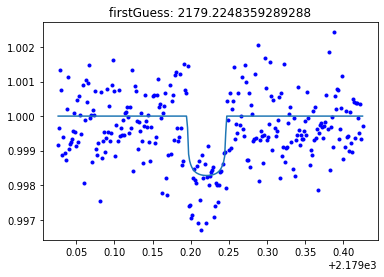

	Transit: 225
		off: -0.003929130914002599
		Ttra guess: 2182.9115767980147
		Chi2 min: 2182.91453085702 (^0.002127159367319109 _-0.002039570380929945)


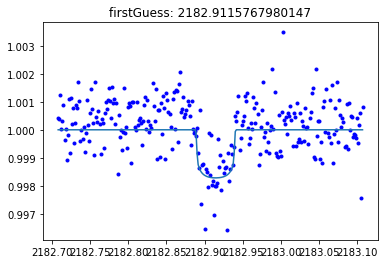

	Transit: 226
		off: 0.002954059005332965
		Ttra guess: 2186.60520085702
		 [] []
		no data points available
	Transit: 227
		off: 0.0
		Ttra guess: 2190.29587085702
		skip_penalty: 1
		Chi2 min: 2190.294983200305 (^0.002352395984416944 _-0.0018143481993320165)


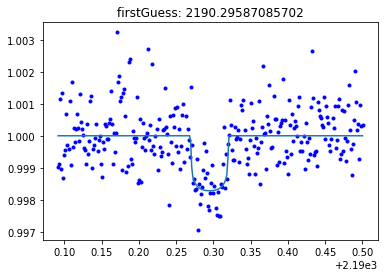

	Transit: 228
		off: -0.0008876567148945469
		Ttra guess: 2193.985653200305
		Chi2 min: 2193.986781253404 (^0.0009009177620100672 _-0.0018769120042634313)


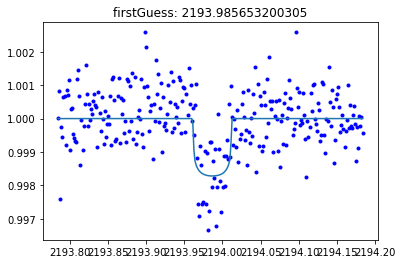

	Transit: 229
		off: 0.0011280530989097315
		Ttra guess: 2197.677451253404
		Chi2 min: 2197.6758934231552 (^0.0021355082203626807 _-0.0006423210802495305)


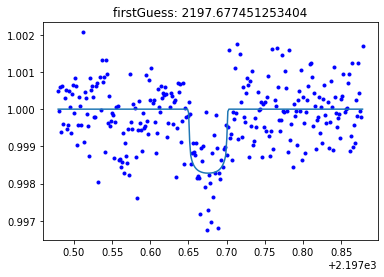

	Transit: 230
		off: -0.0015578302486574103
		Ttra guess: 2201.366563423155
		 [] []
		no data points available
	Transit: 231
		off: 0.0
		Ttra guess: 2205.057233423155
		 [] []
		no data points available
	Transit: 232
		off: 0.0
		Ttra guess: 2208.747903423155
		 [] []
		no data points available
	Transit: 233
		off: 0.0
		Ttra guess: 2212.438573423155
		 [] []
		no data points available
	Transit: 234
		off: 0.0
		Ttra guess: 2216.129243423155
		 [] []
		no data points available
	Transit: 235
		off: 0.0
		Ttra guess: 2219.819913423155
		 [] []
		no data points available
	Transit: 236
		off: 0.0
		Ttra guess: 2223.510583423155
		 [] []
		no data points available
	Transit: 237
		off: 0.0
		Ttra guess: 2227.201253423155
		 [] []
		no data points available
	Transit: 238
		off: 0.0
		Ttra guess: 2230.891923423155
		 [] []
		no data points available
	Transit: 239
		off: 0.0
		Ttra guess: 2234.582593423155
		 [] []
		no data points available
	Transit: 240
		off: 0.0
		Ttra guess: 2238.2732634

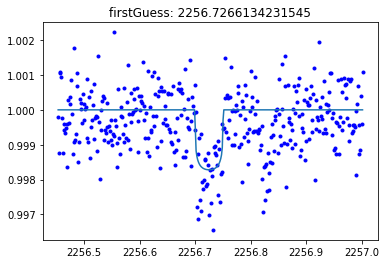

	Transit: 246
		off: -0.0016959837489594065
		Ttra guess: 2260.4155874394055
		Chi2 min: 2260.4166374566557 (^0.0016266581078525633 _-0.0025400884042028338)


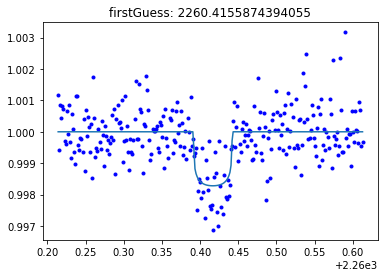

	Transit: 247
		off: 0.0010500172502361238
		Ttra guess: 2264.1073074566557
		Chi2 min: 2264.1084551268464 (^0.0015432366894856386 _-0.0012345893514975614)


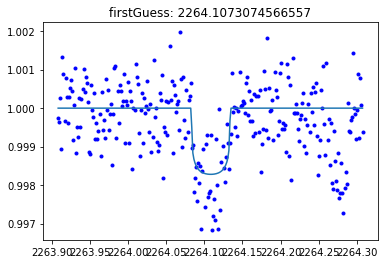

	Transit: 248
		off: 0.0011476701906758535
		Ttra guess: 2267.7991251268463
		 [] []
		no data points available
	Transit: 249
		off: 0.0
		Ttra guess: 2271.4897951268463
		 [] []
		no data points available
	Transit: 250
		off: 0.0
		Ttra guess: 2275.1804651268462
		skip_penalty: 2
		Chi2 min: 2275.1776600647336 (^0.001968664621017524 _-0.0021980641959089553)


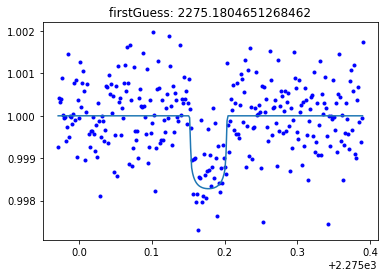

	Transit: 251
		off: -0.002805062112656742
		Ttra guess: 2278.8683300647335
		Chi2 min: 2278.8689066944517 (^0.0010510645934118656 _-0.0017267488747165771)


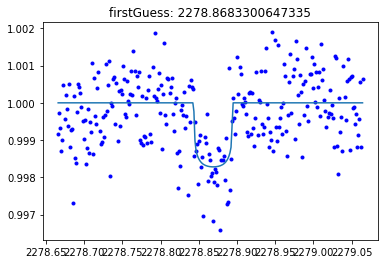

Planets[0]["tperi"](251): 
Planets[0]["tperiErr"](251): 
################################
# start Planet  2
	Transit: 1
		Ttra guess: 1355.28687
		Chi2 min: 1355.2867009558518 (^0.0012679134692916705 _-0.0028986844968130754)


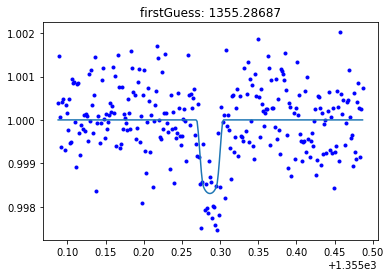

	Transit: 2
		off: -0.00016904414815144264
		Ttra guess: 1362.7374449558517
		Chi2 min: 1362.7368201058134 (^0.002423219498268736 _-0.003132250975795614)


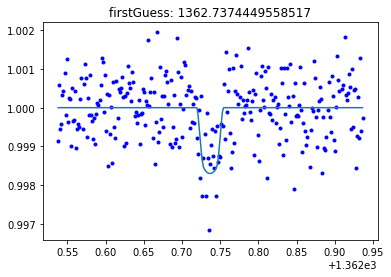

	Transit: 3
		off: -0.0006248500383208011
		Ttra guess: 1370.1875641058134
		Chi2 min: 1370.1909078823583 (^0.0023815191170797334 _-0.0017850965441539302)


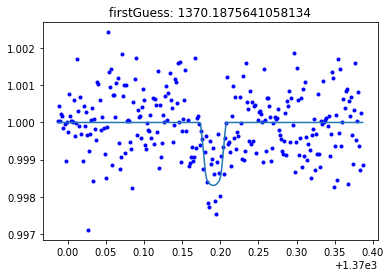

	Transit: 4
		off: 0.003343776544852517
		Ttra guess: 1377.6416518823582
		Chi2 min: 1377.640724806197 (^0.0010927472374078206 _-0.0016849996411565371)


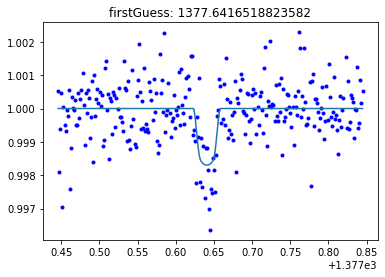

	Transit: 5
		off: -0.0009270761611333
		Ttra guess: 1385.091468806197
		 [] []
		no data points available
	Transit: 6
		off: 0.0
		Ttra guess: 1392.542212806197
		 [] []
		no data points available
	Transit: 7
		off: 0.0
		Ttra guess: 1399.992956806197
		 [] []
		no data points available
	Transit: 8
		off: 0.0
		Ttra guess: 1407.443700806197
		 [] []
		no data points available
	Transit: 9
		off: 0.0
		Ttra guess: 1414.894444806197
		 [] []
		no data points available
	Transit: 10
		off: 0.0
		Ttra guess: 1422.345188806197
		 [] []
		no data points available
	Transit: 11
		off: 0.0
		Ttra guess: 1429.795932806197
		 [] []
		no data points available
	Transit: 12
		off: 0.0
		Ttra guess: 1437.246676806197
		 [] []
		no data points available
	Transit: 13
		off: 0.0
		Ttra guess: 1444.697420806197
		skip_penalty: 8
		Chi2 min: 1444.7757531010782 (^0.0022522856245359435 _-0.0019144427267292485)


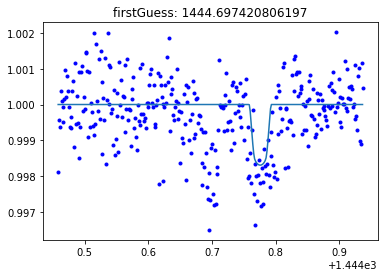

	Transit: 14
		off: 0.07833229488119287
		Ttra guess: 1452.2264971010782
		Chi2 min: 1452.1498810294092 (^0.0018351982339481765 _-0.0023315357052524632)


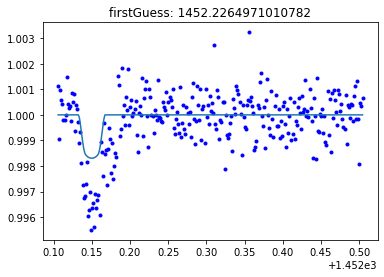

	Transit: 15
		off: -0.07661607166892281
		Ttra guess: 1459.6006250294092
		Chi2 min: 1459.537081674449 (^0.0022689776869810885 _-0.003286680914243334)


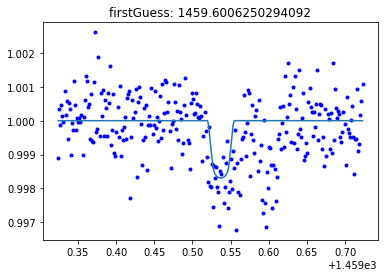

	Transit: 16
		off: -0.06354335496030217
		Ttra guess: 1466.987825674449
		 [] []
		no data points available
	Transit: 17
		off: 0.0
		Ttra guess: 1474.438569674449
		 [] []
		no data points available
	Transit: 18
		off: 0.0
		Ttra guess: 1481.8893136744489
		 [] []
		no data points available
	Transit: 19
		off: 0.0
		Ttra guess: 1489.3400576744489
		 [] []
		no data points available
	Transit: 20
		off: 0.0
		Ttra guess: 1496.7908016744489
		 [] []
		no data points available
	Transit: 21
		off: 0.0
		Ttra guess: 1504.2415456744488
		 [] []
		no data points available
	Transit: 22
		off: 0.0
		Ttra guess: 1511.6922896744488
		 [] []
		no data points available
	Transit: 23
		off: 0.0
		Ttra guess: 1519.1430336744488
		skip_penalty: 7
		Chi2 min: 1519.2044850538912 (^0.0013930911702573212 _-0.0027736697772979824)


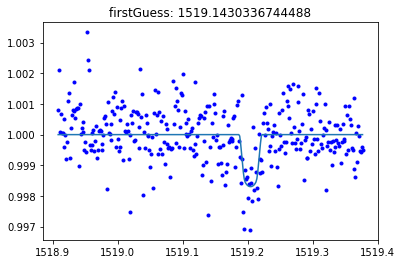

	Transit: 24
		off: 0.06145137944236012
		Ttra guess: 1526.6552290538912
		Chi2 min: 1526.6576475032416 (^0.0025567727352608927 _-0.002998890522576403)


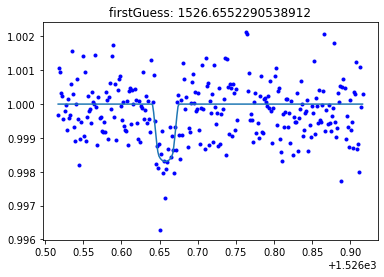

	Transit: 25
		off: 0.0024184493504435522
		Ttra guess: 1534.1083915032416
		 [] []
		no data points available
	Transit: 26
		off: 0.0
		Ttra guess: 1541.5591355032416
		skip_penalty: 1
		Chi2 min: 1541.5574959565333 (^0.0015849394344513712 _-0.002581783328878373)


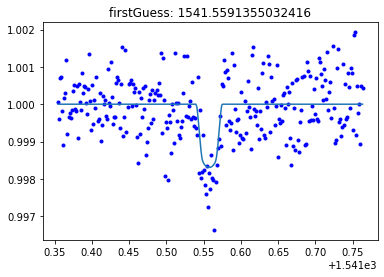

	Transit: 27
		off: -0.001639546708247508
		Ttra guess: 1549.0082399565333
		Chi2 min: 1549.0089307149185 (^0.00026276695894011937 _-0.0025150530284463457)


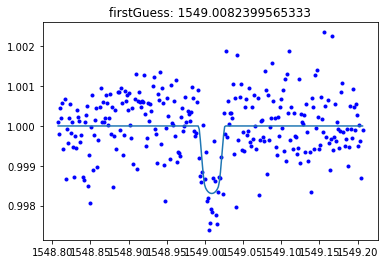

	Transit: 28
		off: 0.000690758385189838
		Ttra guess: 1556.4596747149185
		 [] []
		no data points available
	Transit: 29
		off: 0.0
		Ttra guess: 1563.9104187149185
		skip_penalty: 1
		Chi2 min: 1563.9114049721925 (^0.0021271475175126398 _-0.002039558947672049)


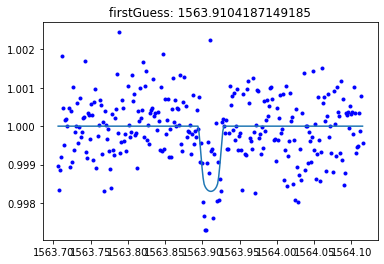

	Transit: 30
		off: 0.0009862572740075848
		Ttra guess: 1571.3621489721925
		Chi2 min: 1571.3618149045972 (^0.0017601068946078158 _-0.0024065916543349886)


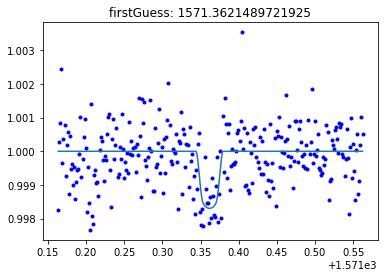

	Transit: 31
		off: -0.00033406759530407726
		Ttra guess: 1578.8125589045972
		Chi2 min: 1578.8133553929945 (^0.0016516565958681895 _-0.0025150233266231226)


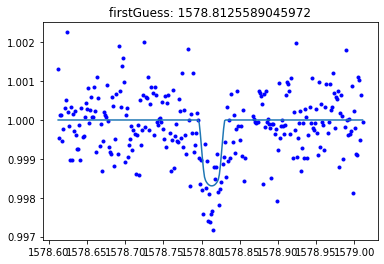

	Transit: 32
		off: 0.0007964883973272663
		Ttra guess: 1586.2640993929945
		Chi2 min: 1586.2646511636742 (^0.0017517551711989654 _-0.0024149196290181862)


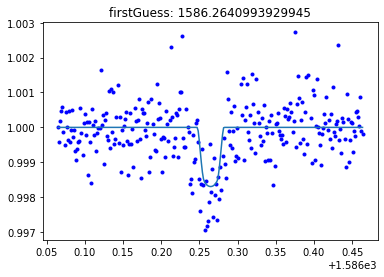

	Transit: 33
		off: 0.0005517706797490973
		Ttra guess: 1593.7153951636742
		Chi2 min: 1593.7130723507744 (^0.0005505489516508533 _-0.0022272193473327206)


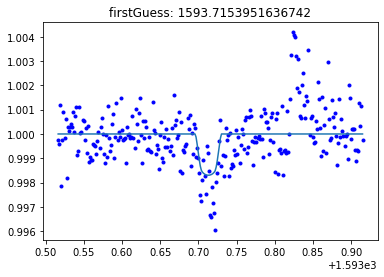

	Transit: 34
		off: -0.002322812899819837
		Ttra guess: 1601.1638163507744
		Chi2 min: 1601.1630135440735 (^0.0019644567275918234 _-0.002202193858238388)


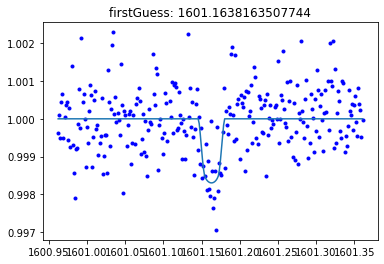

	Transit: 35
		off: -0.0008028067009036022
		Ttra guess: 1608.6137575440735
		Chi2 min: 1608.6153942174797 (^0.002314791962817253 _-0.001851833477303444)


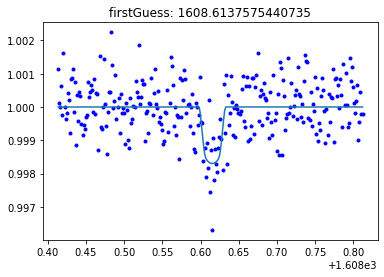

	Transit: 36
		off: 0.0016366734062103205
		Ttra guess: 1616.0661382174796
		Chi2 min: 1616.0633322241094 (^0.0015265123608969589 _-0.002640115873191462)


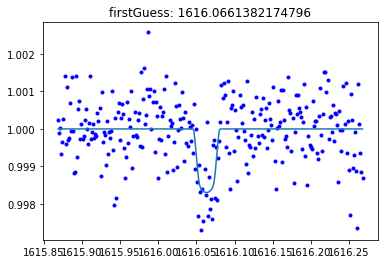

	Transit: 37
		off: -0.0028059933702024864
		Ttra guess: 1623.5140762241094
		Chi2 min: 1623.5163060844461 (^0.0026317566116631497 _-0.00153484414840932)


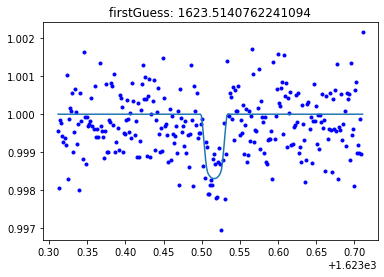

	Transit: 38
		off: 0.002229860336683487
		Ttra guess: 1630.967050084446
		Chi2 min: 1630.9654715890833 (^0.0019769490859289363 _-0.002189658659062843)


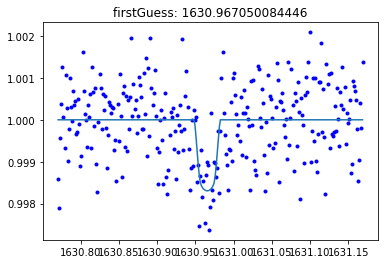

	Transit: 39
		off: -0.0015784953627644427
		Ttra guess: 1638.4162155890833
		Chi2 min: 1638.4142352732265 (^0.003090526126925397 _-0.0024649131478327035)


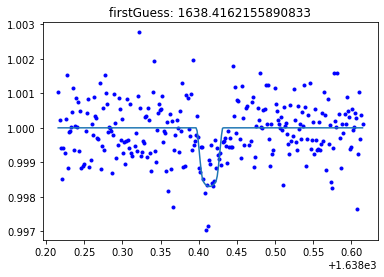

	Transit: 40
		off: -0.0019803158568265644
		Ttra guess: 1645.8649792732265
		Chi2 min: 1645.868710411254 (^0.0012595704686191311 _-0.002907021909550167)


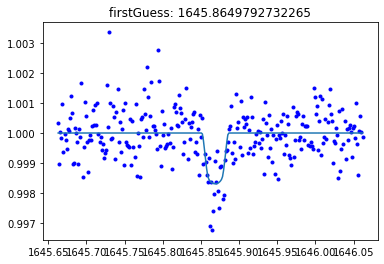

	Transit: 41
		off: 0.0037311380274331896
		Ttra guess: 1653.319454411254
		 [] []
		no data points available
	Transit: 42
		off: 0.0
		Ttra guess: 1660.770198411254
		 [] []
		no data points available
	Transit: 43
		off: 0.0
		Ttra guess: 1668.2209424112539
		 [] []
		no data points available
	Transit: 44
		off: 0.0
		Ttra guess: 1675.6716864112539
		 [] []
		no data points available
	Transit: 45
		off: 0.0
		Ttra guess: 1683.1224304112538
		 [] []
		no data points available
	Transit: 46
		off: 0.0
		Ttra guess: 1690.5731744112538
		 [] []
		no data points available
	Transit: 47
		off: 0.0
		Ttra guess: 1698.0239184112538
		 [] []
		no data points available
	Transit: 48
		off: 0.0
		Ttra guess: 1705.4746624112538
		 [] []
		no data points available
	Transit: 49
		off: 0.0
		Ttra guess: 1712.9254064112538
		 [] []
		no data points available
	Transit: 50
		off: 0.0
		Ttra guess: 1720.3761504112538
		 [] []
		no data points available
	Transit: 51
		off: 0.0
		Ttra guess: 1727.82689441125

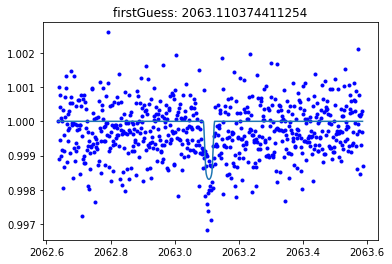

	Transit: 97
		off: -0.0037146743707126006
		Ttra guess: 2070.5574037368833
		Chi2 min: 2070.5588245663116 (^0.0013429810037450807 _-0.0014347374694807513)


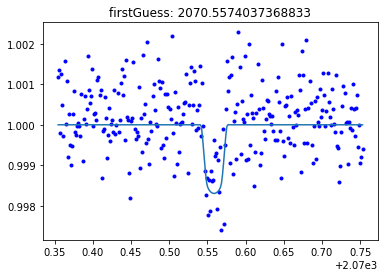

	Transit: 98
		off: 0.0014208294282980205
		Ttra guess: 2078.009568566312
		Chi2 min: 2078.0095769732216 (^0.0018267927734996192 _-0.002339796345040668)


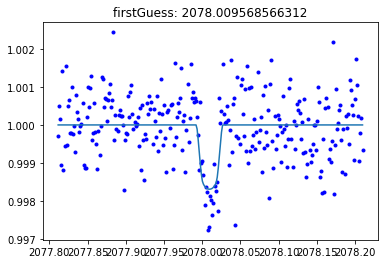

	Transit: 99
		off: 8.406909728364553e-06
		Ttra guess: 2085.4603209732218
		 [] []
		no data points available
	Transit: 100
		off: 0.0
		Ttra guess: 2092.911064973222
		skip_penalty: 1
		Chi2 min: 2092.9106163194715 (^0.0019102140017821512 _-0.0022563881552741805)


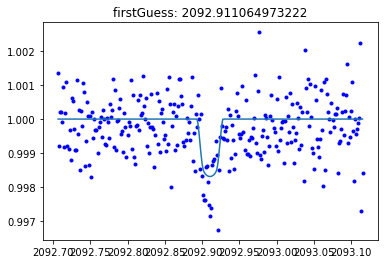

	Transit: 101
		off: -0.0004486537504817534
		Ttra guess: 2100.3613603194717
		 [] []
		no data points available
	Transit: 102
		off: 0.0
		Ttra guess: 2107.812104319472
		skip_penalty: 1
		Chi2 min: 2107.810675823383 (^0.0016432914212600735 _-0.0025233279652638885)


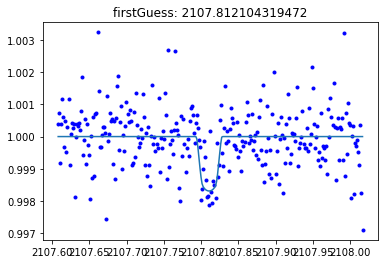

	Transit: 103
		off: -0.0014284960889199283
		Ttra guess: 2115.261419823383
		 [] []
		no data points available
	Transit: 104
		off: 0.0
		Ttra guess: 2122.7121638233834
		 [] []
		no data points available
	Transit: 105
		off: 0.0
		Ttra guess: 2130.1629078233836
		 [] []
		no data points available
	Transit: 106
		off: 0.0
		Ttra guess: 2137.613651823384
		 [] []
		no data points available
	Transit: 107
		off: 0.0
		Ttra guess: 2145.064395823384
		 [] []
		no data points available
	Transit: 108
		off: 0.0
		Ttra guess: 2152.5151398233843
		 [] []
		no data points available
	Transit: 109
		off: 0.0
		Ttra guess: 2159.9658838233845
		 [] []
		no data points available
	Transit: 110
		off: 0.0
		Ttra guess: 2167.4166278233847
		 [] []
		no data points available
	Transit: 111
		off: 0.0
		Ttra guess: 2174.867371823385
		skip_penalty: 8
		Chi2 min: 2174.872115133179 (^0.001368054340218805 _-0.0014097633188612235)


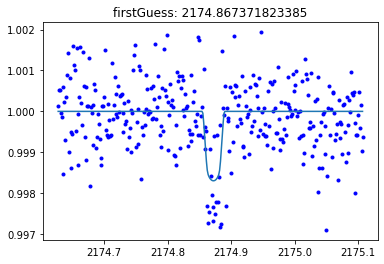

	Transit: 112
		off: 0.004743309793866501
		Ttra guess: 2182.322859133179
		Chi2 min: 2182.319722911935 (^0.001092776064069767 _-0.0016850434576554107)


	Transit: 113
		off: -0.0031362212439489667
		Ttra guess: 2189.7704669119353
		Chi2 min: 2189.7692351947085 (^0.001701733049685572 _-0.002465010668402101)


	Transit: 114
		off: -0.0012317172268012655
		Ttra guess: 2197.2199791947087
		Chi2 min: 2197.2189696641026 (^0.0021063121648694505 _-0.0020604324845407973)


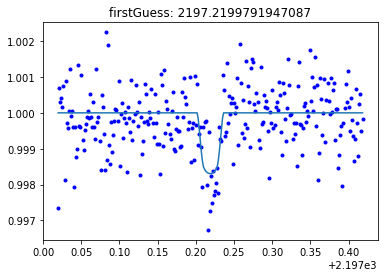

	Transit: 115
		off: -0.0010095306060975417
		Ttra guess: 2204.669713664103
		 [] []
		no data points available
	Transit: 116
		off: 0.0
		Ttra guess: 2212.120457664103
		 [] []
		no data points available
	Transit: 117
		off: 0.0
		Ttra guess: 2219.5712016641032
		 [] []
		no data points available
	Transit: 118
		off: 0.0
		Ttra guess: 2227.0219456641034
		 [] []
		no data points available
	Transit: 119
		off: 0.0
		Ttra guess: 2234.4726896641037
		 [] []
		no data points available
	Transit: 120
		off: 0.0
		Ttra guess: 2241.923433664104
		 [] []
		no data points available
	Transit: 121
		off: 0.0
		Ttra guess: 2249.374177664104
		 [] []
		no data points available
	Transit: 122
		off: 0.0
		Ttra guess: 2256.8249216641043
		skip_penalty: 7
		Chi2 min: 2256.7188612554196 (^0.00210631769414249 _-0.0020604371998160786)


	Transit: 123
		off: -0.1060604086846979
		Ttra guess: 2264.16960525542
		Chi2 min: 2264.105143424329 (^0.002077113165796618 _-0.003478538916169782)


	Transit: 124
		off: -0.064461831090739
		Ttra guess: 2271.5558874243293
		 [] []
		no data points available
	Transit: 125
		off: 0.0
		Ttra guess: 2279.0066314243295
		skip_penalty: 1
		Chi2 min: 2278.8753674038862 (^0.0015348876650023158 _-0.0026318318386984174)


Planets[1]["tperi"](125): 
Planets[1]["tperiErr"](125): 


In [59]:
%matplotlib inline
import matplotlib.pyplot as plt


for i,P in enumerate(periods):
    # i=1
    # P=periods[i]
    Planets[i]["tperiGuess"] =[]
    Planets[i]["tperiCalc"]  =[]
    Planets[i]["tperi"]      =[]
    Planets[i]["tperiErr"]   =[]
    Planets[i]["time"]       =[]
    Planets[i]["modelFlux"]  =[]
    Planets[i]["dataFlux"]   =[]
    
    
    print('################################')
    print('# start Planet ', i+1)
    skip_penalty = 0
    skip_penalty_factor = 0.005
    for j, T0 in enumerate(np.arange(tperis[i], np.max(time), P)): # tperis[i], tperis[i]+20, P)): # 
        # map transit midpoints, data and models
        # print('tperi: ',T0)
        # print(T0)
        off = 0
        if j>0:
            off = Planets[i]["tperi"][-1] - Planets[i]["tperiGuess"][-1]
        Planets[i]["tperiCalc"].append(T0)
        if not silent:
            print(f'\tTransit: {j+1}')
        
        if j>0:
            print(f'\t\toff: {off}')
            T0 = Planets[i]["tperi"][-1]+P
            
        Planets[i]["tperiGuess"].append(T0)
        Planets[i]["tperi"].append(T0)
        Planets[i]["tperiErr"].append(np.zeros(2))
        
        if not silent:
            print(f'\t\tTtra guess: {T0}')
        
        
        tmp_time=[]
        for t in time:
            dT_tmp = dT+skip_penalty*skip_penalty_factor
            if (T0+T0off+off-dT_tmp<t<T0+T0off+off+dT_tmp):
                a = True
            else:
                a = False
            tmp_time.append(a)
        inds = np.where(tmp_time)
        
        params = Parameters()
        
        if value[inds].size>0:
            # print("inds: ",inds)
            
            Planets[i]["time"].append(time[inds])
            ##########################################################
            # initialize parameters and fix all exept T0 for fit
            
            params.add("Rp2Rs", value = Rp2Rss[i], vary=False)
            params.add("ldc0", value = ldc0, vary=False)
            params.add("ldc1", value = ldc1, vary=False)
            params.add("P", value = P, vary=False)
            params.add("a2Rs", value = a2Rss[i], vary=False)
            params.add("e", value = es[i], vary=False)
            params.add("om", value = oms[i], vary=False)
            
            params.add("inc", value = incs[i], vary=incVary)
            params.add("T0", value=T0 + T0off, vary =False) # min=T0+T0off-0.8*dT, max=T0+T0off+0.8*dT)
            params.add("off", value=0, min=-0.001, max=0.001, vary= False)
            
            
            Planets[i]["valErr"].append(np.mean(error[inds]))
            if (plotData or plotAll) and not silent:
                # print(f'\t\t len[inds]: {len(inds[0])}')
                # print(inds)
                # print(len(time[inds]), time[inds])
                # print(len(value[inds]),value[inds])
                plt.plot(time[inds], value[inds])
                plt.show()
                
            if ownChi2:
                chi2planet = []
                for ind in inds[0]:
                    params["T0"].value= time[ind]
                    chi2planet.append(chi2(params, inds, value[inds], error[inds]))
                # print(len(chi2planet), chi2planet)
                
                minFitRange = int(round(minFitRangeFactor*len(chi2planet)))
                minInd = chi2planet.index(np.min(chi2planet))
                if time[inds][minInd-minFitRange:minInd+minFitRange].size<3:
                    print("time array for chi2 empty")
                    skip_penalty += 1
                    continue
                
#                 viableFitRange = False
#                 while not viableFitRange:
#                     try:
#                         viableFitRange = True
#                         time[inds][minInd+minFitRange]
#                         time[inds][minInd-minFitRange]
#                     except IndexError:
#                         viableFitRange = False
#                         if minFitRange == int(0.9*minFitRange):
#                             raise IndexError(f"minFitRange to small for Transit {j} of Planet {i}")
                            
#                         minFitRange= int(0.9*minFitRange)
                    
#                 if minFitRange<=5:
#                     print("fitRange for Chi2 too small, skipping this Transit")
#                     skip_penalty += 1
#                     continue
                
                # print(time[inds][minInd-minFitRange:minInd+minFitRange])
                # print(chi2planet[minInd-minFitRange:minInd+minFitRange])
                
                # minFit,cov = np.polyfit(time[inds][minInd-minFitRange:minInd+minFitRange],
                #                     chi2planet[minInd-minFitRange:minInd+minFitRange],2, cov=True)
                minFit= np.polyfit(time[inds][minInd-minFitRange:minInd+minFitRange],
                                   chi2planet[minInd-minFitRange:minInd+minFitRange],2)
                
                # print(minFit)
                
                minFitPoly = np.poly1d(minFit)
                
                if plotAll and not silent:                
                    plt.plot(time[inds[0]], chi2planet)
                    
                    plt.show()
                try:
                    nx = np.linspace(time[inds][minInd-minFitRange],time[inds][minInd+minFitRange],1000)
                except IndexError:
                    print(f'\t\tindex error, skipping this transit')
                    skip_penalty += 1
                    continue
                    
                if skip_penalty > 0:
                    print(f"\t\tskip_penalty: {skip_penalty}")
                    
                if plotAll and not silent:
                    plt.plot(time[inds][minInd-minFitRange:minInd+minFitRange], chi2planet[minInd-minFitRange:minInd+minFitRange])
                    plt.plot(nx, minFitPoly(nx))
                    plt.show()
                
                chi2min = min(minFitPoly(nx))
                ttraChi2 = min(nx[np.where(minFitPoly(nx)==(chi2min))])
                
                ######################################
                # calc error (chi2+1 environment)
                
                ttraChi2err=[0,0]
                for x,t in zip(chi2planet[minInd-minFitRange:minInd],time[inds][minInd-minFitRange:minInd]):
                    if np.floor(x) >= chi2min+1:
                        ttraChi2err[0] = t-ttraChi2
                    else:
                        break
                for x,t in zip(chi2planet[minInd:minInd+minFitRange],time[inds][minInd:minInd+minFitRange]):
                    if np.ceil(x) >= chi2min+1:
                        ttraChi2err[1] = t-ttraChi2
                        break
                
            skip_penalty = 0
                                
            # if Chi2:
                #try to implement chi2 from lmfit again to get sigma intervals
            
            if not silent:
                print(f'\t\tChi2 min: {ttraChi2} (^{ttraChi2err[1]} _{ttraChi2err[0]})')
            
            Planets[i]["tperi"][-1]=ttraChi2
            Planets[i]["tperiErr"][-1]=ttraChi2err
            
            
            # print("flux: ",flux[inds])
            params["T0"].value = ttraChi2
            Planets[i]["modelFlux"].append(list(model(inds, params)))
            Planets[i]["dataFlux"].append(list(value[inds]))
            
            if (plotFit or plotAll) and not silent:
                plt.plot(Planets[i]["time"][-1], Planets[i]["dataFlux"][-1],'b.')
                plt.plot(Planets[i]["time"][-1], Planets[i]["modelFlux"][-1])
                plt.title("firstGuess: " + str(Planets[i]["tperiGuess"][-1]))
                plt.show()
        else:
            if not silent:
                print(f'\t\t',time[inds], value[inds])
                print(f'\t\tno data points available')
            skip_penalty += 1
    
              
    
    
    print(f'Planets[{i}]["tperi"]({len(Planets[i]["tperi"])}): ')#, Planets[i]["tperi"])
    print(f'Planets[{i}]["tperiErr"]({len(Planets[i]["tperiErr"])}): ')#, Planets[i]["tperiErr"])
    Planets[i]["tperiErr"]=np.asarray(Planets[i]["tperiErr"])  
    # sys.exit()

In [60]:
print(len(Planets[0]['tperiGuess']))
print(len(Planets[0]['tperi']))


251
251


m:  3.69067747773673 , c:  1356.2015569139685


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


m:  7.450707027483535 , c:  1355.2906033638028


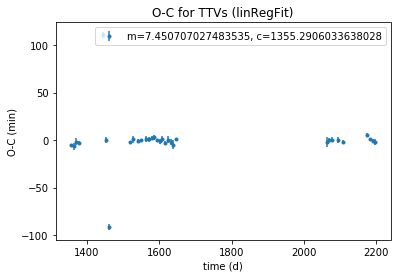

In [61]:
Planets[1]["tperiErr"]=Planets[1]["tperiErr"][:-4]
Planets[1]["tperi"]=Planets[1]["tperi"][:-4]
for i,plan in enumerate(Planets):
    yerr = np.zeros(len(plan["tperiErr"]))
    yerr_2 = []
    tperi_2 = []
    ti = []
    for j,err in enumerate(plan["tperiErr"]):
        if max(err) == 0:
            yerr[j] = 10000
        else:
            yerr[j] = max(err)*24*60
            yerr_2.append(max(err)*24*60)
            tperi_2.append(plan['tperi'][j])
            ti.append(j)
#     N=len(plan['tperi'])
#     A = np.vstack([np.ones(N), range(N)]).T
#     c, m = np.linalg.lstsq(A, plan['tperi'])[0]
#     print('m: ',m,', c: ',c)
#     plt.errorbar(np.array(range(N))*periods[i]+plan["tperi"][0], (plan['tperi']-m*np.array(range(N))-c)*(24.*60), yerr=yerr, label=f'm={m}, c={c}')
    N=len(tperi_2)
    M=max(ti)
    A = np.vstack([np.ones(N),ti]).T
    c, m = np.linalg.lstsq(A, tperi_2)[0]
    print('m: ',m,', c: ',c)
    pp = PdfPages(f"TTV{np.round(m,2)}.pdf")
    plt.errorbar(tperi_2, (tperi_2-m*np.asarray(ti)-c)*(24.*60), yerr=yerr_2, label=f'm={m}, c={c}', fmt='.')
    plt.xlabel('time (d)')
    plt.ylabel('O-C (min)')
    plt.title(f'O-C for TTVs (linRegFit)')
    plt.legend()
    pp.savefig(plt.gcf(), bbox_inches='tight') # This generates pdf page
    pp.close()
    plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


m:  3.69067747773673 , c:  1356.2015569139685
0 2.1056694034996326
1 1.172472097860009
2 5.488819163183507
3 0.13962567165435757
4 4.393543980986578
5 0.05414354232925689
6 2.1239392099596444
7 0.7586634822291671
8 3.7139198939257767
9 -2.717207186651649
10 1.9009810236821068
11 0.5173318217202905
12 0.29443416260619415
13 -1.7230657067557331
14 -1.741342116256419
15 -0.25357333121064585
16 -1.2646294219666743
17 -0.3512406755180564
18 -0.9803048630055855
19 -3.1868399937957292
20 -2.130052991087723
21 0.5149333191729966
22 -1.4955664947774494
23 -0.7319014101085486
24 -1.5973308223328786
25 -2.2472555253625615
26 0.09513195938779972
27 -2.684451422501297
28 -2.977561778097879
29 -1.628467086229648
30 -0.6875169572595041
31 -1.9393757822763291
32 -2.244557058074861
33 -0.5939806902460987
34 -0.6771598311024718
35 -0.38419977317971643
36 -1.4845120417521684
37 -0.1415276790430653
38 0.4987563400209183
39 -0.7046842045747326
40 -0.17761810806405265
41 0.15684734207752626
42 -0.8928061613

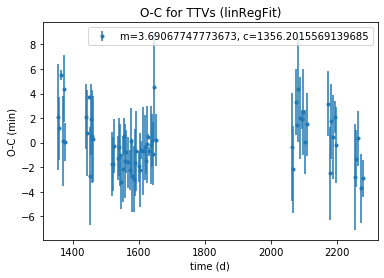

standard deviation:  2.0670777948350536
median error:  2.644649192407087
period:  3.69067
slope:  3.69067747773673
difference:  7.47773673026586e-06
m:  7.450719920148599 , c:  1355.289507300233
0 -4.041135909028526
1 -4.9062449783377815
2 -0.05653176755004097
3 -1.356846453709295
4 1.4612648319962318
5 -1.2391050400037784
6 2.278137010835053
7 -0.013460277295962442
8 1.0159067835775204
9 2.5054672302212566
10 2.0590848788560834
11 3.240703156880045
12 4.069927921918861
13 0.7597523320509936
14 -0.36161433137749555
15 2.029870359765482
16 -1.9760851074534003
17 1.2695887635709369
18 -0.9687695729371626
19 -3.7857494208947173
20 1.6217643248091917
21 -1.78556755228783
22 0.2951018106614356
23 0.34188274719781475
24 -0.2348286810956779
25 -2.2225130760853062


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


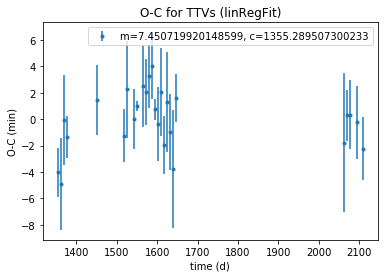

standard deviation:  2.2045001050282815
median error:  2.582567761037353
period:  7.450744
slope:  7.450719920148599
difference:  -2.4079851400848895e-05


In [65]:
Planets[1]["tperiErr"]=Planets[1]["tperiErr"][:-4]
Planets[1]["tperi"]=Planets[1]["tperi"][:-4]


for i,plan in enumerate(Planets):
    yerr = np.zeros(len(plan["tperiErr"]))
    yerr_2 = []
    tperi_2 = []
    ti = []
    for j,err in enumerate(plan["tperiErr"]):
        if max(err) == 0:
            yerr[j] = 10000
        else:
            yerr[j] = max(err)*24*60
            yerr_2.append(max(err)*24*60)
            tperi_2.append(plan['tperi'][j])
            ti.append(j)
            
    if i==1:
        tperi_2.pop(4)
        yerr_2.pop(4)
        ti.pop(4)
        tperi_2.pop(5)
        yerr_2.pop(5)
        ti.pop(5)
    
#     N=len(plan['tperi'])
#     A = np.vstack([np.ones(N), range(N)]).T
#     c, m = np.linalg.lstsq(A, plan['tperi'])[0]
#     print('m: ',m,', c: ',c)
#     plt.errorbar(np.array(range(N))*periods[i]+plan["tperi"][0], (plan['tperi']-m*np.array(range(N))-c)*(24.*60), yerr=yerr, label=f'm={m}, c={c}')
    N=len(tperi_2)
    M=max(ti)
    A = np.vstack([np.ones(N),ti]).T
    c, m = np.linalg.lstsq(A, tperi_2)[0]
    print('m: ',m,', c: ',c)
    pp = PdfPages(f"TTV{np.round(m,2)}.pdf")
    
    TT = (tperi_2-m*np.asarray(ti)-c)*(24.*60)
    for a,b in enumerate(TT):
        print(a,b)
                        
    plt.errorbar(tperi_2, (tperi_2-m*np.asarray(ti)-c)*(24.*60), yerr=yerr_2, label=f'm={m}, c={c}', fmt='.')
    plt.xlabel('time (d)')
    plt.ylabel('O-C (min)')
    plt.title(f'O-C for TTVs (linRegFit)')
    plt.legend()
    pp.savefig(plt.gcf(), bbox_inches='tight') # This generates pdf page
    pp.close()
    plt.show()
    TT = (tperi_2-m*np.asarray(ti)-c)*(24.*60)

    print('standard deviation: ',np.std(TT))
    print('median error: ', np.median(yerr_2))
    print('period: ', periods[i])
    print('slope: ', m)
    print('difference: ', m-periods[i])

In [63]:
TT = (tperi_2-m*np.asarray(ti)-c)*(24.*60)

print(np.std(TT))
print(np.mean(yerr_2))

15.858031247161417
2.616544574706378
